Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_3_6.png  &  C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_3_6.svg


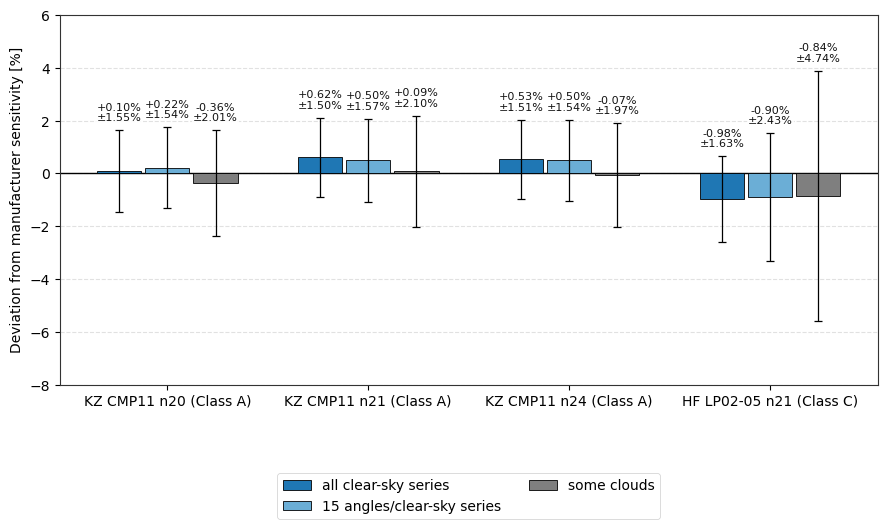

In [17]:
# -*- coding: utf-8 -*-
"""
Figure 3.3.6 — Sensitivity vs manufacturer (deviation) for several outdoor series
Bars = deviation from manufacturer [%]  → (value_pct - 100)
Error bars = provided uncertainties [%]
Legend = series (“Out, all clear-sky…”, “Out, 15 angles…”, “Out, some clouds”)
X-axis = sensor IDs (pyranometers)

Input CSV (as per instructions):
  outdoor_sensitivites.csv
Columns:
  Pyranometer, ID, "In, manufacturer", unc,
  "Out, all clear-sky series", unc,
  "Out, 15 angles/clear-sky series", unc,
  "Out, some clouds", unc

No extra packages needed besides numpy/pandas/matplotlib.
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- Paths -----------------------
BASE_DIR= r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets", "calibration_outdoor_filtering")
INP_FILE = os.path.join(INP_DIR, "outdoor_sensitivities.csv")  # (spelling per your note)
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")
# os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------- Target series & colors -----------------------
# Bar groups (legend order)
SERIES_ORDER = [
    "Out, all clear-sky series",
    "Out, 15 angles/clear-sky series",
    "Out, some clouds",
]

SERIES_ORDER = [
    "all clear-sky series",
    "15 angles/clear-sky series",
    "some clouds",
]

# Thesis-consistent colors (Fig 3.3.2 palette family)
SERIES_COLORS = {
    "all clear-sky series":        "#1f77b4",  # blue
    "15 angles/clear-sky series":  "#6baed6",  # light blue
    "some clouds":                 "#7f7f7f",  # grey
}

# ----------------------- Helpers -----------------------
def _norm(s: str) -> str:
    """Normalize header for matching: lowercase, strip spaces."""
    return re.sub(r"\s+", " ", str(s).strip().lower())

def _clean_percent(x: str) -> float:
    """Convert '100.10%' or '1,55%' etc. to float; spreadsheet placeholders → NaN."""
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.upper() in {"#N/A", "#REF!", "#DIV/0!"}:
        return np.nan
    s = (
        s.replace("\u00A0", "")
         .replace("\u2009", "")
         .replace(" ", "")
         .replace(",", ".")
         .replace("%", "")
    )
    try:
        return float(s)
    except ValueError:
        return np.nan

def _resolve_col(df_cols, wanted):
    """Resolve a column name by case/space-insensitive match."""
    norm_map = {_norm(c): c for c in df_cols}
    key = _norm(wanted)
    return norm_map.get(key, None)

def load_and_prepare(path: str):
    """
    Read CSV and build:
      sensors: list of ID strings for x-ticks
      dev:     dict[series] -> np.array of deviations (value - 100)
      unc:     dict[series] -> np.array of uncertainties
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Input CSV not found: {path}")

    df = pd.read_csv(path, dtype=str)
    cols = list(df.columns)

    # Resolve key columns
    id_col = _resolve_col(cols, "Pyranometer")
    if id_col is None:
        raise KeyError("Neither 'ID' nor 'Pyranometer' column found in CSV.")

    # Optional: "In, manufacturer" exists but we only need it to compute deviation baseline (=100%)
    # The CSV already lists percentages around 100, so deviation = value - 100.
    # We will compute from the three 'Out' series directly.

    # Build data arrays
    sensors = df[id_col].astype(str).tolist()

    dev = {}
    unc = {}

    # We'll pair each target series with the *next* column whose normalized name starts with 'unc'
    for series in SERIES_ORDER:
        s_col = _resolve_col(cols, series)
        if s_col is None:
            raise KeyError(f"Series column not found (header mismatch): '{series}'")

        # Find its uncertainty column: next column to the right that looks like 'unc'
        s_idx = cols.index(s_col)
        unc_col = None
        for k in range(s_idx + 1, min(s_idx + 3, len(cols))):  # look ahead one or two positions
            if _norm(cols[k]).startswith("unc"):
                unc_col = cols[k]
                break
        # If not found, fall back to the last 'unc' column to the right
        if unc_col is None:
            for k in range(s_idx + 1, len(cols)):
                if _norm(cols[k]).startswith("unc"):
                    unc_col = cols[k]
                    break
        if unc_col is None:
            raise KeyError(f"Uncertainty column not found to pair with series '{series}'.")

        # Parse numeric values (percent)
        v = df[s_col].apply(_clean_percent).to_numpy(dtype=float)
        u = df[unc_col].apply(_clean_percent).to_numpy(dtype=float)

        dev[series] = v - 100.0  # deviation from manufacturer baseline
        unc[series] = u

    return sensors, dev, unc

def _nice_ylim_for_bars_with_error(dev_mat: np.ndarray, err_mat: np.ndarray):
    """
    Set y-limits to include (y ± err) with headroom for labels.
    dev_mat, err_mat shape: (n_series, n_sensors)
    """
    lo = np.nanmin(dev_mat - np.nan_to_num(err_mat, nan=0.0))
    hi = np.nanmax(dev_mat + np.nan_to_num(err_mat, nan=0.0))
    span = max(hi - lo, 1.0)
    pad  = max(0.18 * span, 0.4)  # ≥ 0.4 %-pt headroom
    return (np.floor(lo - pad), np.ceil(hi + pad))

# ----------------------- Plot -----------------------
def plot_figure_3_3_6(sensors, dev, unc):
    """
    Grouped bars (x = sensors, bars = 'Out' series), with error bars and 2-decimal labels.
    """
    # Matrix layout: rows by series in SERIES_ORDER, columns by sensor index
    data_dev = np.vstack([dev[s] for s in SERIES_ORDER])  # shape: S x N
    data_unc = np.vstack([unc[s] for s in SERIES_ORDER])

    S, N = data_dev.shape
    x = np.arange(N)
    bar_w = min(0.8 / max(S, 1), 0.22)
    pad   = 0.02

    fig, ax = plt.subplots(figsize=(9.4, 5.6))
    plt.rcParams.update({
        "axes.edgecolor": "#333",
        "axes.linewidth": 0.8,
        "grid.color": "#bdbdbd",
        "grid.linestyle": "--",
        "grid.alpha": 0.45,
        "axes.grid": True,
        "font.size": 10,
    })

    # Compute y-limits with error bars accounted
    y_min, y_max = _nice_ylim_for_bars_with_error(data_dev, data_unc)

    # Draw bars + error bars + labels
    for j, series in enumerate(SERIES_ORDER):
        offs = (j - (S - 1) / 2) * (bar_w + pad)
        y = data_dev[j, :]
        e = data_unc[j, :]

        ax.bar(
            x + offs, y, width=bar_w,
            color=SERIES_COLORS.get(series, "#888"),
            edgecolor="black", linewidth=0.6,
            label=series, zorder=3
        )
        ax.errorbar(
            x + offs, y, yerr=e, fmt="none",
            ecolor="black", elinewidth=0.9, capsize=3, capthick=0.9, zorder=4
        )
        # Labels "value% ± err%" on top (two decimals)
        span = max(y_max - y_min, 1e-6)
        up_off = 0.02 * span
        for i in range(N):
            if not np.isfinite(y[i]):
                continue
            if np.isfinite(e[i]):
                # txt = f"{(y[i]+100):.2f}%\n±{e[i]:.2f}%"  # print the absolute % value (not deviation)
                txt = f"{(y[i]):+.2f}%\n±{e[i]:.2f}%"
                top = y[i] + e[i]
            else:
                # txt = f"{(y[i]+100):.2f}%"
                txt = f"{(y[i]):+.2f}%" 
                top = y[i]
            ax.text(
                x[i] + offs, top + up_off, txt,
                ha="center", va="bottom", fontsize=8.0, color="#111",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=0.8),
                linespacing=1.05, clip_on=False, zorder=5
            )

    # Axes & cosmetics
    ax.axhline(0.0, color="k", linewidth=1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(sensors)
    ax.set_xlabel("")  # no x label per your style
    ax.set_ylabel("Deviation from manufacturer sensitivity [%]")
    ax.set_ylim(y_min, y_max)

    # Grid only on Y
    ax.grid(True, axis="y")
    ax.grid(False, axis="x")

    # Legend below    
    leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2, frameon=True)
    leg.get_frame().set_linewidth(0.6)

    fig.subplots_adjust(bottom=0.30, left=0.11, right=0.98, top=0.96)

    # Save
    png = os.path.join(OUT_DIR, "Figure_3_3_6.png")
    svg = os.path.join(OUT_DIR, "Figure_3_3_6.svg")
    fig.savefig(png, dpi=300)
    fig.savefig(svg)
    print(f"Saved: {png}  &  {svg}")

# ----------------------- Run -----------------------
def main():
    sensors, dev, unc = load_and_prepare(INP_FILE)
    plot_figure_3_3_6(sensors, dev, unc)

if __name__ == "__main__":
    main()